# The Continuous Thought Machine – Tutorial 01: MNIST [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SakanaAI/continuous-thought-machines/blob/main/examples/01_mnist.ipynb) [![arXiv](https://img.shields.io/badge/arXiv-2505.05522-b31b1b.svg)](https://arxiv.org/abs/2505.05522)

Modern deep learning models ignore time as a core computational element. In contrast, the **Continuous Thought Machine (CTM)** introduces internal recurrence and neural synchronization to model *thinking as a temporal process*.

### Key Ideas

- **Internal Ticks**: The CTM runs over a self-generated temporal axis (independent of input), which we via as a dimension over which though can unfold.
- **Neuron-Level Models**: Each neuron has a private MLP that processes its own history of pre-activations over time.
- **Synchronization as Representation**: CTMs compute neuron-to-neuron synchronization over time and use these signals for attention and output.

### Why It Matters

- Enables **interpretable, dynamic reasoning**
- Supports **adaptive compute** (e.g. more ticks for harder tasks)
- Works across tasks: classification, reasoning, memory, RL—*without changing the core mechanisms*.

----

### MNIST Classification

In this tutorial we walk through a simple example; training a CTM to classify MNIST digits. We cover:
- Defining the model
- Constructing the loss function
- Training
- Building vizualization

Imports

In [16]:
!pip install mediapy

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from scipy.special import softmax
import math
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import mediapy


We start by defining some helper classes, which we will use in the CTM.

Of note is the SuperLinear class, which implements N unique linear transformations. This SuperLinear class will be used for the neuron-level models.

In [18]:
class Identity(nn.Module):
    """Identity Module."""
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

class Squeeze(nn.Module):
    """Squeeze Module."""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return x.squeeze(self.dim)

class SuperLinear(nn.Module):
    """SuperLinear Layer: Implements Neuron-Level Models (NLMs) for the CTM."""
    def __init__(self, in_dims, out_dims, N):
        super().__init__()
        self.in_dims = in_dims
        self.register_parameter('w1', nn.Parameter(
            torch.empty((in_dims, out_dims, N)).uniform_(
                -1/math.sqrt(in_dims + out_dims),
                 1/math.sqrt(in_dims + out_dims)
            ), requires_grad=True)
        )
        self.register_parameter('b1', nn.Parameter(torch.zeros((1, N, out_dims)), requires_grad=True))

    def forward(self, x):
            out = torch.einsum('BDM,MHD->BDH', x, self.w1) + self.b1
            out = out.squeeze(-1)
            return out

Next, we define a helper function `compute_normalized_entropy`. We will use this function inside the CTM to compute the certainty of the model at each internal tick as `certainty = 1 - normalized entropy`.

In [19]:
def compute_normalized_entropy(logits, reduction='mean'):
    """Computes the normalized entorpy for certainty-loss."""
    preds = F.softmax(logits, dim=-1)
    log_preds = torch.log_softmax(logits, dim=-1)
    entropy = -torch.sum(preds * log_preds, dim=-1)
    num_classes = preds.shape[-1]
    max_entropy = torch.log(torch.tensor(num_classes, dtype=torch.float32))
    normalized_entropy = entropy / max_entropy
    if len(logits.shape)>2 and reduction == 'mean':
        normalized_entropy = normalized_entropy.flatten(1).mean(-1)
    return normalized_entropy

## CTM Architecture Overview

The CTM implementation is initialized with the following core parameters:

- `iterations`: Number of internal ticks (recurrent steps).
- `d_model`: Total number of neurons.
- `d_input`: Input and attention embedding dimension.
- `memory_length`: Length of the sliding activation window used by each neuron.
- `heads`: Number of attention heads.
- `n_synch_out`: Number of neurons used for output synchronization.
- `n_synch_action`: Number of neurons used for computing attention queries.
- `out_dims`: Dimensionality of the model's output.

### Key Components

Upon initialization, the CTM builds the following modules:

- **Backbone**: A CNN feature extractor for the input (e.g. image).
- **Synapses**: A communication layer allowing neurons to interact.
- **Trace Processor**: A neuron-level model that operates on each neuron's temporal activation trace.
- **Synchronization Buffers**: For tracking decay.
- **Learned Initial States**: Starting activations and traces for the system.

---

## Forward Pass Mechanics

At each internal tick `stepi`, the CTM executes the following procedure:

1. **Initialize recurrent state**:
    - `state_trace`: Memory trace per neuron.
    - `activated_state`: Current post-activations.
    - `decay_alpha_out`, `decay_beta_out`: Values for calculating synchronization.

2. **Featurize input**:
    - Use the CNN backbone to extract key-value attention pairs `kv`.

3. **Internal Loop** (for each tick `stepi`):
    1. Compute `synchronisation_action` from `n_synch_action` neurons.
    2. Generate attention query `q` from this synchronization.
    3. Perform multi-head cross-attention over `kv`.
    4. Concatenate attention output with the current neuron activations.
    5. Update neurons via the synaptic module.
    6. Append new activation to the trace window.
    7. Update neuron states using the `trace_processor`.
    8. Compute `synchronisation_out` from `n_synch_out` neurons.
    9. Project to the output space via `output_projector`.
    10. Compute prediction certainty from normalized entropy.

This inner loop is repeated for the configured number of internal ticks. The CTM emits **predictions and certainties at every internal tick**.

> For detailed mathematical formulation of the synchronization mechanism, please refer to the technical report.

In [20]:
class ContinuousThoughtMachine(nn.Module):
    def __init__(self,
                 iterations,
                 d_model,
                 d_input,
                 memory_length,
                 heads,
                 n_synch_out,
                 n_synch_action,
                 out_dims,
                 memory_hidden_dims,
                 ):
        super(ContinuousThoughtMachine, self).__init__()

        # --- Core Parameters ---
        self.iterations = iterations
        self.d_model = d_model
        self.d_input = d_input
        self.memory_length = memory_length
        self.n_synch_out = n_synch_out
        self.n_synch_action = n_synch_action
        self.out_dims = out_dims
        self.memory_length = memory_length
        self.memory_hidden_dims = memory_hidden_dims

        # --- Input Processing  ---
        self.backbone = nn.Sequential(
            nn.LazyConv2d(d_input, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(d_input),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.LazyConv2d(d_input, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(d_input),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.attention = nn.MultiheadAttention(self.d_input, heads, batch_first=True)
        self.kv_proj = nn.Sequential(nn.LazyLinear(self.d_input), nn.LayerNorm(self.d_input))
        self.q_proj = nn.LazyLinear(self.d_input)

        # --- Core CTM Modules ---
        self.synapses = nn.Sequential(
                nn.LazyLinear(d_model * 2),
                nn.GLU(),
                nn.LayerNorm(d_model)
            )
        self.trace_processor = nn.Sequential(
            SuperLinear(in_dims=memory_length, out_dims=2 * memory_hidden_dims, N=d_model),
            nn.GLU(),
            SuperLinear(in_dims=memory_hidden_dims, out_dims=2, N=d_model),
            nn.GLU(),
            Squeeze(-1)
        )

        #  --- Start States ---
        self.register_parameter('start_activated_state', nn.Parameter(
                torch.zeros((d_model)).uniform_(-math.sqrt(1/(d_model)), math.sqrt(1/(d_model))),
                requires_grad=True
            ))

        self.register_parameter('start_trace', nn.Parameter(
            torch.zeros((d_model, memory_length)).uniform_(-math.sqrt(1/(d_model+memory_length)), math.sqrt(1/(d_model+memory_length))),
            requires_grad=True
        ))

        # --- Synchronisation ---
        self.synch_representation_size_action = (self.n_synch_action * (self.n_synch_action+1))//2
        self.synch_representation_size_out = (self.n_synch_out * (self.n_synch_out+1))//2

        for synch_type, size in [('action', self.synch_representation_size_action), ('out', self.synch_representation_size_out)]:
            print(f"Synch representation size {synch_type}: {size}")

        self.set_synchronisation_parameters('out', self.n_synch_out)
        self.set_synchronisation_parameters('action', self.n_synch_action)

        # --- Output Procesing ---
        self.output_projector = nn.Sequential(nn.LazyLinear(self.out_dims))

    def set_synchronisation_parameters(self, synch_type: str, n_synch: int):
        left, right = self.initialize_left_right_neurons(synch_type, self.d_model, n_synch)
        synch_representation_size = self.synch_representation_size_action if synch_type == 'action' else self.synch_representation_size_out
        self.register_buffer(f'{synch_type}_neuron_indices_left', left)
        self.register_buffer(f'{synch_type}_neuron_indices_right', right)
        self.register_parameter(f'decay_params_{synch_type}', nn.Parameter(torch.zeros(synch_representation_size), requires_grad=True))

    def initialize_left_right_neurons(self, synch_type, d_model, n_synch):
        if synch_type == 'out':
            neuron_indices_left = neuron_indices_right = torch.arange(0, n_synch)
        elif synch_type == 'action':
            neuron_indices_left = neuron_indices_right = torch.arange(d_model-n_synch, d_model)
        return neuron_indices_left, neuron_indices_right

    def compute_synchronisation(self, activated_state, decay_alpha, decay_beta, r, synch_type):
        if synch_type == 'action':
            n_synch = self.n_synch_action
            selected_left = selected_right = activated_state[:, -n_synch:]
        elif synch_type == 'out':
            n_synch = self.n_synch_out
            selected_left = selected_right = activated_state[:, :n_synch]

        outer = selected_left.unsqueeze(2) * selected_right.unsqueeze(1)
        i, j = torch.triu_indices(n_synch, n_synch)
        pairwise_product = outer[:, i, j]

        if decay_alpha is None or decay_beta is None:
            decay_alpha = pairwise_product
            decay_beta = torch.ones_like(pairwise_product)
        else:
            decay_alpha = r * decay_alpha + pairwise_product
            decay_beta = r * decay_beta + 1

        synchronisation = decay_alpha / (torch.sqrt(decay_beta))
        return synchronisation, decay_alpha, decay_beta

    def compute_features(self, x):
        input_features = self.backbone(x)
        kv = self.kv_proj(input_features.flatten(2).transpose(1, 2))
        return kv

    def compute_certainty(self, current_prediction):
        ne = compute_normalized_entropy(current_prediction)
        current_certainty = torch.stack((ne, 1-ne), -1)
        return current_certainty

    def forward(self, x, track=False):
        B = x.size(0)
        device = x.device

        # --- Tracking Initialization ---
        pre_activations_tracking = []
        post_activations_tracking = []
        synch_out_tracking = []
        synch_action_tracking = []
        attention_tracking = []

        # --- Featurise Input Data ---
        kv = self.compute_features(x)

        # --- Initialise Recurrent State ---
        state_trace = self.start_trace.unsqueeze(0).expand(B, -1, -1) # Shape: (B, H, T)
        activated_state = self.start_activated_state.unsqueeze(0).expand(B, -1) # Shape: (B, H)

        # --- Storage for outputs per iteration
        predictions = torch.empty(B, self.out_dims, self.iterations, device=device, dtype=x.dtype)
        certainties = torch.empty(B, 2, self.iterations, device=device, dtype=x.dtype)

        decay_alpha_action, decay_beta_action = None, None
        self.decay_params_action.data = torch.clamp(self.decay_params_action, 0, 15)  # Fix from github user: kuviki
        self.decay_params_out.data = torch.clamp(self.decay_params_out, 0, 15)
        r_action, r_out = torch.exp(-self.decay_params_action).unsqueeze(0).repeat(B, 1), torch.exp(-self.decay_params_out).unsqueeze(0).repeat(B, 1)

        _, decay_alpha_out, decay_beta_out = self.compute_synchronisation(activated_state, None, None, r_out, synch_type='out')

        # --- Recurrent Loop  ---
        for stepi in range(self.iterations):

            # --- Calculate Synchronisation for Input Data Interaction ---
            synchronisation_action, decay_alpha_action, decay_beta_action = self.compute_synchronisation(activated_state, decay_alpha_action, decay_beta_action, r_action, synch_type='action')

            # --- Interact with Data via Attention ---
            q = self.q_proj(synchronisation_action).unsqueeze(1)
            attn_out, attn_weights = self.attention(q, kv, kv, average_attn_weights=False, need_weights=True)
            attn_out = attn_out.squeeze(1)
            pre_synapse_input = torch.concatenate((attn_out, activated_state), dim=-1)

            # --- Apply Synapses ---
            state = self.synapses(pre_synapse_input)
            state_trace = torch.cat((state_trace[:, :, 1:], state.unsqueeze(-1)), dim=-1)

            # --- Activate ---
            activated_state = self.trace_processor(state_trace)

            # --- Calculate Synchronisation for Output Predictions ---
            synchronisation_out, decay_alpha_out, decay_beta_out = self.compute_synchronisation(activated_state, decay_alpha_out, decay_beta_out, r_out, synch_type='out')

            # --- Get Predictions and Certainties ---
            current_prediction = self.output_projector(synchronisation_out)
            current_certainty = self.compute_certainty(current_prediction)

            predictions[..., stepi] = current_prediction
            certainties[..., stepi] = current_certainty

            # --- Tracking ---
            if track:
                pre_activations_tracking.append(state_trace[:,:,-1].detach().cpu().numpy())
                post_activations_tracking.append(activated_state.detach().cpu().numpy())
                attention_tracking.append(attn_weights.detach().cpu().numpy())
                synch_out_tracking.append(synchronisation_out.detach().cpu().numpy())
                synch_action_tracking.append(synchronisation_action.detach().cpu().numpy())

        # --- Return Values ---
        if track:
            return predictions, certainties, (np.array(synch_out_tracking), np.array(synch_action_tracking)), np.array(pre_activations_tracking), np.array(post_activations_tracking), np.array(attention_tracking)
        return predictions, certainties, synchronisation_out

## Certainty-Based Loss Function

The CTM produces outputs at each internal tick, so the question arises: **how do we optimize the model across this internal temporal dimension?**

Our answer is a simple but effective **certainty-based loss** that encourages the model to reason meaningfully across time. Instead of relying on the final tick alone, we aggregate loss from two key internal ticks:

1. The tick where the **prediction loss** is lowest.
2. The tick where the **certainty** (1 - normalized entropy) is highest.

We then take the **average of the losses** at these two points.

This approach encourages the CTM to both make accurate predictions and express high confidence in them—while supporting adaptive, interpretable computation over time.


In [21]:
def get_loss(predictions, certainties, targets, use_most_certain=True):
    """use_most_certain will select either the most certain point or the final point."""

    losses = nn.CrossEntropyLoss(reduction='none')(predictions,
                                                   torch.repeat_interleave(targets.unsqueeze(-1), predictions.size(-1), -1))

    loss_index_1 = losses.argmin(dim=1)
    loss_index_2 = certainties[:,1].argmax(-1)
    if not use_most_certain:
        loss_index_2[:] = -1

    batch_indexer = torch.arange(predictions.size(0), device=predictions.device)
    loss_minimum_ce = losses[batch_indexer, loss_index_1].mean()
    loss_selected = losses[batch_indexer, loss_index_2].mean()

    loss = (loss_minimum_ce + loss_selected)/2
    return loss, loss_index_2

In [22]:
def calculate_accuracy(predictions, targets, where_most_certain):
    """Calculate the accuracy based on the prediction at the most certain internal tick."""
    B = predictions.size(0)
    device = predictions.device

    predictions_at_most_certain_internal_tick = predictions.argmax(1)[torch.arange(B, device=device), where_most_certain].detach().cpu().numpy()
    accuracy = (targets.detach().cpu().numpy() == predictions_at_most_certain_internal_tick).mean()

    return accuracy

In [23]:
def prepare_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=1)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, num_workers=1, drop_last=False)
    return trainloader, testloader

In [24]:
def train(model, trainloader, testloader, iterations, device):

  test_every = 100

  optimizer = torch.optim.AdamW(params=list(model.parameters()), lr=0.0001, eps=1e-8)

  model.train()

  with tqdm(total=iterations, initial=0, dynamic_ncols=True) as pbar:
      test_loss = None
      test_accuracy = None
      for stepi in range(iterations):

          inputs, targets = next(iter(trainloader))
          inputs, targets = inputs.to(device), targets.to(device)
          predictions, certainties, _ = model(inputs, track=False)
          train_loss, where_most_certain = get_loss(predictions, certainties, targets)
          train_accuracy = calculate_accuracy(predictions, targets, where_most_certain)

          optimizer.zero_grad()
          train_loss.backward()
          optimizer.step()

          if stepi % test_every == 0:
            model.eval()
            with torch.inference_mode():
                all_test_predictions = []
                all_test_targets = []
                all_test_where_most_certain = []
                all_test_losses = []

                for inputs, targets in testloader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    predictions, certainties, _ = model(inputs, track=False)
                    test_loss, where_most_certain = get_loss(predictions, certainties, targets)
                    all_test_losses.append(test_loss.item())

                    all_test_predictions.append(predictions)
                    all_test_targets.append(targets)
                    all_test_where_most_certain.append(where_most_certain)

                all_test_predictions = torch.cat(all_test_predictions, dim=0)
                all_test_targets = torch.cat(all_test_targets, dim=0)
                all_test_where_most_certain = torch.cat(all_test_where_most_certain, dim=0)

                test_accuracy = calculate_accuracy(all_test_predictions, all_test_targets, all_test_where_most_certain)
                test_loss = sum(all_test_losses) / len(all_test_losses)
            model.train()

          pbar.set_description(f'Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f} Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}')
          pbar.update(1)

  return model

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trainloader, testloader = prepare_data()

model = ContinuousThoughtMachine(
    iterations = 30,
    d_model = 128,
    d_input = 32,
    memory_length = 15,
    heads = 1,
    n_synch_out = 16,
    n_synch_action = 16,
    memory_hidden_dims = 8,
    out_dims = 10,
  ).to(device)


model = train(model=model, trainloader=trainloader, testloader=testloader, iterations=2000, device=device)

Synch representation size action: 136
Synch representation size out: 136


  0%|          | 0/2000 [00:00<?, ?it/s]

Train Loss: 0.226, Train Accuracy: 0.891 Test Loss: 0.256, Test Accuracy: 0.893: 100%|██████████| 2000/2000 [08:43<00:00,  3.82it/s]


## Visualizing CTM Dynamics

We define a function to create GIFs that show how the CTMs dynamics. These visualizations include:

- **Neuron activations** at each internal tick  
- **Attention patterns** across the input  
- **Predictions and certainty** at every step

In [26]:
def make_gif(predictions, certainties, targets, pre_activations, post_activations, attention, inputs_to_model, filename):
    def reshape_attention_weights(attention_weights):
        T, B = attention_weights.shape[0], attention_weights.shape[1]
        grid_size = math.sqrt(attention_weights.shape[-1])
        assert grid_size.is_integer(), f'Grid size should be a perfect square, but got {attention_weights.shape[-1]}'
        H_ATTENTION = W_ATTENTION = int(grid_size)
        attn_weights_reshaped = attention_weights.reshape(T, B, -1, H_ATTENTION, W_ATTENTION)
        return attn_weights_reshaped.mean(2)

    batch_index = 0
    n_neurons_to_visualise = 16
    figscale = 0.28
    n_steps = len(pre_activations)
    heCTMap_cmap = sns.color_palette("viridis", as_cmap=True)
    frames = []

    attention = reshape_attention_weights(attention)

    these_pre_acts = pre_activations[:, batch_index, :]
    these_post_acts = post_activations[:, batch_index, :]
    these_inputs = inputs_to_model[batch_index,:, :, :]
    these_attention_weights = attention[:, batch_index, :, :]
    these_predictions = predictions[batch_index, :, :]
    these_certainties = certainties[batch_index, :, :]
    this_target = targets[batch_index]

    class_labels = [str(i) for i in range(these_predictions.shape[0])]

    mosaic = [['img_data', 'img_data', 'attention', 'attention', 'probs', 'probs', 'probs', 'probs'] for _ in range(2)] + \
             [['img_data', 'img_data', 'attention', 'attention', 'probs', 'probs', 'probs', 'probs'] for _ in range(2)] + \
             [['certainty'] * 8] + \
             [[f'trace_{ti}'] * 8 for ti in range(n_neurons_to_visualise)]

    for stepi in range(n_steps):
        fig_gif, axes_gif = plt.subplot_mosaic(mosaic=mosaic, figsize=(31*figscale*8/4, 76*figscale))
        probs = softmax(these_predictions[:, stepi])
        colors = [('g' if i == this_target else 'b') for i in range(len(probs))]

        axes_gif['probs'].bar(np.arange(len(probs)), probs, color=colors, width=0.9, alpha=0.5)
        axes_gif['probs'].set_title('Probabilities')
        axes_gif['probs'].set_xticks(np.arange(len(probs)))
        axes_gif['probs'].set_xticklabels(class_labels, fontsize=24)
        axes_gif['probs'].set_yticks([])
        axes_gif['probs'].tick_params(left=False, bottom=False)
        axes_gif['probs'].set_ylim([0, 1])
        for spine in axes_gif['probs'].spines.values():
            spine.set_visible(False)
        axes_gif['probs'].tick_params(left=False, bottom=False)
        axes_gif['probs'].spines['top'].set_visible(False)
        axes_gif['probs'].spines['right'].set_visible(False)
        axes_gif['probs'].spines['left'].set_visible(False)
        axes_gif['probs'].spines['bottom'].set_visible(False)

        # Certainty
        axes_gif['certainty'].plot(np.arange(n_steps), these_certainties[1], 'k-', linewidth=2)
        axes_gif['certainty'].set_xlim([0, n_steps-1])
        axes_gif['certainty'].axvline(x=stepi, color='black', linewidth=1, alpha=0.5)
        axes_gif['certainty'].set_xticklabels([])
        axes_gif['certainty'].set_yticklabels([])
        axes_gif['certainty'].grid(False)
        for spine in axes_gif['certainty'].spines.values():
            spine.set_visible(False)

        # Neuron Traces
        for neuroni in range(n_neurons_to_visualise):
            ax = axes_gif[f'trace_{neuroni}']
            pre_activation = these_pre_acts[:, neuroni]
            post_activation = these_post_acts[:, neuroni]
            ax_pre = ax.twinx()

            ax_pre.plot(np.arange(n_steps), pre_activation, color='grey', linestyle='--', linewidth=1, alpha=0.4)
            color = 'blue' if neuroni % 2 else 'red'
            ax.plot(np.arange(n_steps), post_activation, color=color, linewidth=2, alpha=1.0)

            ax.set_xlim([0, n_steps-1])
            ax_pre.set_xlim([0, n_steps-1])
            ax.set_ylim([np.min(post_activation), np.max(post_activation)])
            ax_pre.set_ylim([np.min(pre_activation), np.max(pre_activation)])

            ax.axvline(x=stepi, color='black', linewidth=1, alpha=0.5)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.grid(False)
            ax_pre.set_xticklabels([])
            ax_pre.set_yticklabels([])
            ax_pre.grid(False)

            for spine in ax.spines.values():
                spine.set_visible(False)
            for spine in ax_pre.spines.values():
                spine.set_visible(False)

        # Input image
        this_image = these_inputs[0]
        this_image = (this_image - this_image.min()) / (this_image.max() - this_image.min() + 1e-8)
        axes_gif['img_data'].set_title('Input Image')
        axes_gif['img_data'].imshow(this_image, cmap='binary', vmin=0, vmax=1)
        axes_gif['img_data'].axis('off')

        # Attention
        this_input_gate = these_attention_weights[stepi]
        gate_min, gate_max = np.nanmin(this_input_gate), np.nanmax(this_input_gate)
        if not np.isclose(gate_min, gate_max):
            normalized_gate = (this_input_gate - gate_min) / (gate_max - gate_min + 1e-8)
        else:
            normalized_gate = np.zeros_like(this_input_gate)
        attention_weights_heCTMap = heCTMap_cmap(normalized_gate)[:,:,:3]

        axes_gif['attention'].imshow(attention_weights_heCTMap, vmin=0, vmax=1)
        axes_gif['attention'].axis('off')
        axes_gif['attention'].set_title('Attention')

        fig_gif.tight_layout()
        canvas = fig_gif.canvas
        canvas.draw()
        image_numpy = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
        image_numpy = image_numpy.reshape(*reversed(canvas.get_width_height()), 4)[:, :, :3]
        frames.append(image_numpy)
        plt.close(fig_gif)


    mediapy.show_video(frames, width=400, codec="gif")
    imageio.mimsave(filename, frames, fps=5, loop=100)

The top row of the gif shows the input image, the attention weights and the models predictions.

The second plot, in black, shows the models certainty over time.

The red and blue lines correspond to the post-activations of different neurons, with the corresponding pre-activation shown in gray.

""

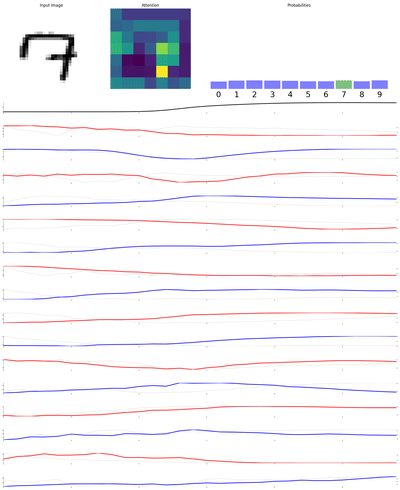

In [28]:
model.eval()
with torch.inference_mode():
    inputs, targets = next(iter(testloader))
    inputs = inputs.to(device)

    predictions, certainties, (synch_out_tracking, synch_action_tracking), \
    pre_activations_tracking, post_activations_tracking, attention = model(inputs, track=True)

    filename = "mnist_output.gif"

    make_gif(
        predictions.detach().cpu().numpy(),
        certainties.detach().cpu().numpy(),
        targets.detach().cpu().numpy(),
        pre_activations_tracking,
        post_activations_tracking,
        attention,
        inputs.detach().cpu().numpy(),
        filename
    )